Codigo para simular y optimizar granja eolica en el cual se puede implementar una turbina, Site y WinfFarmModel personalizados.

Informacion adicional: 
1) Se utiliza la libreria Pywake para simular la granja eolica y la libria TOPFARM para optimizar las ubicaciones de los aerogeneradores. 

2) Las coordenadas de las posiciones de las turbinas se encuentran en formato UTM, estas deben ser numeros enteros (Para utilizar grados decimales ver ejemplos en la pagina oficial de PyWake).
Conversor de coordenadas utilizado: https://www.sirgaschile.cl/ConversionSC/Convertidor.php

3) En el codigo se corren 2 casos, uno con el total de datos de viento (promedios mensuales desde 1940-2022) y el otro con estos mismos datos pero filtrando con el 40% mejor. 

4) Segun los datos de viento utilizados se deben obtener los parametros de escala y forma de Weibull y un vector de sector de frecuencias (probabilidades de viento en cada direccion).

In [1]:
# Librerias generales
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Librerias de pywake
from py_wake.site._site import UniformWeibullSite # tipo de Site
from py_wake.wind_turbines import WindTurbine # generar la turbina
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular # funcion para generar turbina 

Se suben los datos de la turbina NREL_5MW_126_RWT obtenidos de :

1) Radio del rotor  y altura de buje: https://nrel.github.io/turbine-models/NREL_5MW_126_RWT.html#link-to-tabular-data
2) Curva de potencia y CT: https://github.com/DTUWindEnergy/PyWake/tree/master/py_wake/examples/data/iea37


In [2]:
datos_turbina = 'NREL_5MW_126_RWT.csv'
datos = pd.read_csv(datos_turbina) # leer archivo csv

power_curve = np.array(datos.iloc[:, 1]) # datos de la curva de potencia en kwh
ct_curve = np.array(datos.iloc[:, 4]) # datos de la curva CT
velocidad = np.array(datos.iloc[:,0]) # velocidades de referencia en m/s
diametro = 126 # metros
altura_buje = 90 # metros

nombre = 'NREL_5MW_RWT'

Se establecen los limites y coordenadas iniciales de los aerogeneradores

In [3]:
# Limites en coordenadas UTM para la creacion de posiciones iniciales
wt_x = list(range(629002, 637218, 100))
wt_y = list(range(5935661,5955176, 100))

# Posiciones inciales de 18 turbinas, coordenadas UTM 
wt18_x = np.array(wt_x)[[1, 80, 40, 52, 12, 30, 20, 60, 82,57, 45, 33, 51, 42, 43, 69, 71, 44]]
wt18_y = np.array(wt_y)[[133, 2, 50, 140, 40, 102, 65, 90, 183,100, 72, 70, 120, 76, 100, 75, 80, 83]]

Ahora se crea la turbina utilizando los datos subidos anteriormente mediante una funcion definida en PyWake llamada PowerCtFunction y tambien se crea el Site que corresponde a la informacion para las condiciones de viento de la zona. Para esto ultimo se utiliza una clase llamada UniformWeibullSite y los valores ingresados (a,k,f) se obtienen mediante MATLAB los cuales corresponden al parametro de escala de la distribucion de Weibull, parametro de forma de la distribucion de Weibul y el sector de frecuencia respectivamente.

Recordar que UniformWeibullSite implica una velocidad del viento uniforme dependiente del sector y distribuida por Weibull.

In [4]:
# TURBINA
# ya definidos sus parametros en la primera celda de cogido no se modifica nada 
class MyTurbine(WindTurbine):
    def __init__(self):
        u = velocidad
        diameter = diametro
        hub_height = altura_buje
        PowerCtFunction = PowerCtTabular(u, power_curve, 'kW', ct_curve)
        WindTurbine.__init__(self, name=nombre, diameter=diameter, hub_height=hub_height, powerCtFunction=PowerCtFunction)        
# para llamarla "call_turbine = MyTurbine()"

# SITE
# se deben reemplazar los valores f_nuevo, a_nuevo y k_nuevo mencionados antes
class Prueba1SiteNuevo(UniformWeibullSite):
    def __init__(self, ti=.1, shear=None):
        f_nuevo = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0.00198807157057654,0.0526838966202783,0.465208747514911,0.150099403578529,0.0536779324055666,0.0278330019880716,0.0238568588469185,0.0188866799204771,0.0159045725646123,0.0188866799204771,0.0159045725646123,0.0208747514910537,0.0198807157057654,0.0228628230616302,0.0248508946322068,0.0288270377733598,0.0198807157057654,0.0129224652087475]
        a_nuevo = [6.456142487468540]*36  # parametro de escala
        # el valor *36 corresponde al largo del vector de sector de frecuencias f_nuevo
        k_nuevo = 1.897125380076016 # parametro de forma
        # ti: turbulence_intensity valor default 0.1
        UniformWeibullSite.__init__(self, f_nuevo, a_nuevo, [k_nuevo] * 36, ti=ti, shear=shear)
        self.initial_position = np.array([wt18_x, wt18_y]).T
# para llamarlo "call_site = Prueba1Sitenuevo()"

Graficamos la curva de potencia y CT de la turbina 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


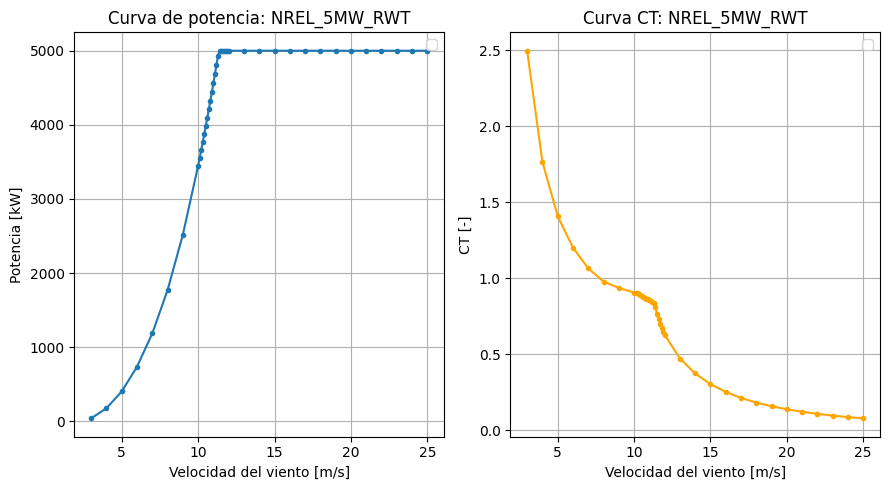

In [5]:
#plt.figure(figsize=(10, 10))
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.plot(velocidad, power_curve,'.-')
plt.legend(loc=1)
plt.xlabel('Velocidad del viento [m/s]')
plt.ylabel('Potencia [kW]')
plt.title('Curva de potencia: ' + nombre)
plt.grid(True) 

plt.subplot(1, 2, 2)
plt.plot(velocidad,  ct_curve,'.-', color='orange')
plt.legend(loc=1)
plt.xlabel('Velocidad del viento [m/s]')
plt.ylabel('CT [-]')
plt.title('Curva CT: ' + nombre)
plt.grid(True)

plt.tight_layout()  # Ajustar automáticamente el espaciado entre subgráficos
plt.show()

Hasta aqui esta lista la turbina, coordenadas iniciales y la informacion del viento (direccion y velocidad mediante el Site). A continuacion se muestran algunos graficos para visualizar las condiciones de viento.

Text(0.5, 1.0, 'Rosa de los vientos, Caso 1')

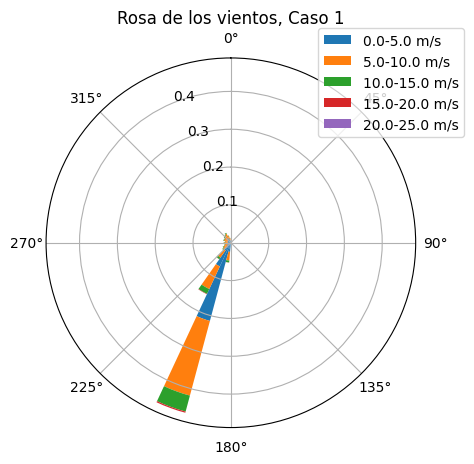

In [6]:
# Para llamar la Turbina y Site creados
windturbine = MyTurbine()
site = Prueba1SiteNuevo()

# Se puede visualizar una rosa de los vientos creada segun los parametros de Weibull
plt.figure()
_ = site.plot_wd_distribution(n_wd=36,ws_bins=[0,5,10,15,20,25]) 
# n_wd: numero de secciones, ws_binds: rangos de velocidad  
plt.title('Rosa de los vientos, Caso 1')


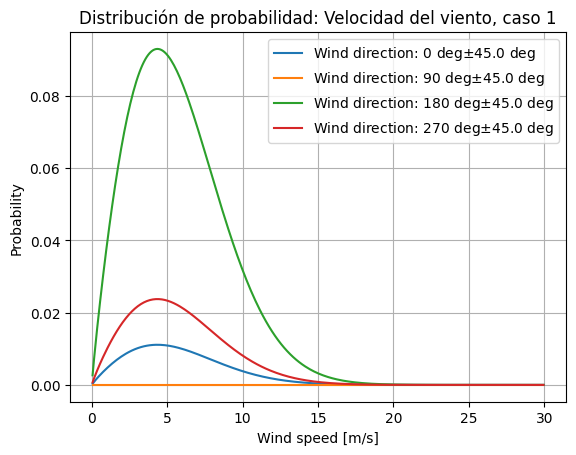

In [7]:
# Tambien se puede observar las probabilidades de la velocidad del viento segun su direccion 
plt.figure()
plt.title('Distribución de probabilidad: Velocidad del viento, caso 1')
_ = site.plot_ws_distribution(wd=[0,90,180,270], include_wd_distribution=True)
plt.grid(True)

Ahora se realiza la simulacion a partir del objeto WindFarmModel tambien personalizado, esto ultimo se refiere a que el usuario elige los modulos de las funciones que utilizara. Por ejemplo, el modelo de deficit de estela, superposicion, bloqueo, entre otros. 

Para este caso, se utiliza el modelo de ingenieria All2AllIterative que considera el efecto estela de de los aerogeneradores 'aguas abajo'. El modelo de deficit de estela FugaDeficit, el modelo de superposicion LinearSum y el modelo de bloqueo FugaDeficit que es uno de los pocos que agregan el efecto bloqueo en la parte frontal del aerogenerador. 

Para mas opciones de estos modelos visitar el sitio oficial de PyWake. 

In [8]:
# Librerias de los modelos  
from py_wake.superposition_models import LinearSum
from py_wake.deficit_models import *
from py_wake.deficit_models.deficit_model import *
from py_wake.wind_farm_models import *
from py_wake.rotor_avg_models import *
from py_wake.superposition_models import *
from py_wake.deflection_models import *
from py_wake.turbulence_models import *
from py_wake.ground_models import *
from py_wake.deficit_models.utils import *

# El nombre del objeto es wfm, dentro de el se definen el site, turbina y los modelos a utilizar.
wfm = All2AllIterative(
    site,
    windturbine,
    wake_deficitModel=FugaDeficit(
        rotorAvgModel=None,
        groundModel=None),
    superpositionModel=LinearSum(),
    deflectionModel=None,
    turbulenceModel=None,
    blockage_deficitModel=FugaDeficit(),
    rotorAvgModel=None)

# Se define un vector de direcciones de referencia desde los 0 a los 360 grados. 
# Aca se puede establecer un rango especifico para la simulacion y el calculo del AEP
wd2 = np.linspace(0.,360.,360, endpoint=False) # de 0 a 360 grados con paso 1

c:\Users\lator\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Corremos la simulacion dando como resultado el AEP

In [9]:
# Con simulationResult se corre la simulacion ingresando las posiciones iniciales de los aerogeneradores
# y el rango de direcciones de velocidad donde se haran los calculos
simulationResult = wfm(wt18_x, wt18_y, wd= wd2)

simulationResult.aep() # calcula el aep para cada aerogenerador

# Para mostrar el AEP de la granja eolica
print ("Total AEP: %f GWh"%simulationResult.aep().sum()) 

Total AEP: 169.724030 GWh


Una vez corrida la simulacion, se pueden obtener un mapa de flujo en la direccion y velocidad que el usuario indique (esto netamente para visualizar la estela)

Text(0.5, 1.0, 'Initial Wake Map: 10 m/s, 225 deg')

<Figure size 640x480 with 0 Axes>

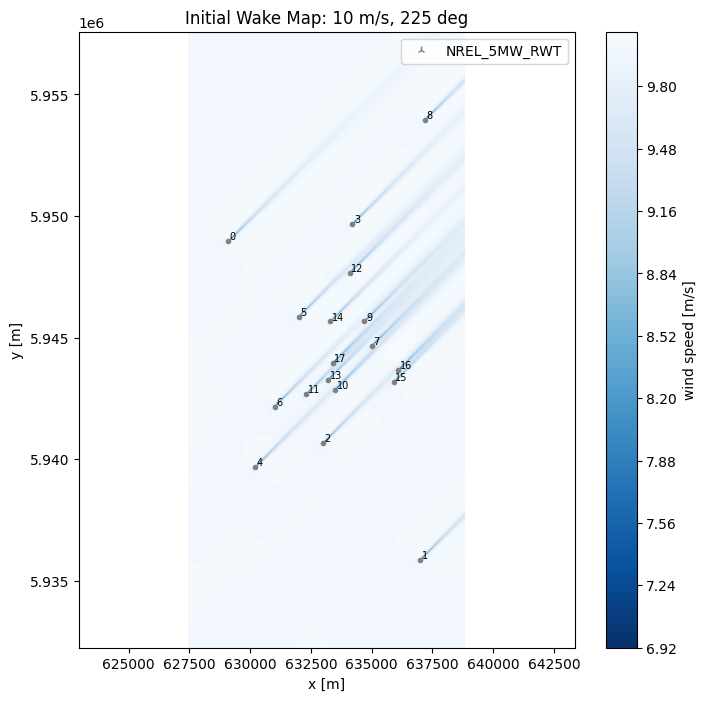

In [10]:
wind_speed = 10 #m/s
wind_direction = 225 # grados (de donde proviene el viento)
plt.figure()
flow_map = simulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(8,8))
flow_map.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Initial Wake Map:' + f' {wind_speed} m/s, {wind_direction} deg')

Tambien se obtienen otros graficos como:

Text(0.5, 1.0, 'AEP vs wind direction')

<Figure size 640x480 with 0 Axes>

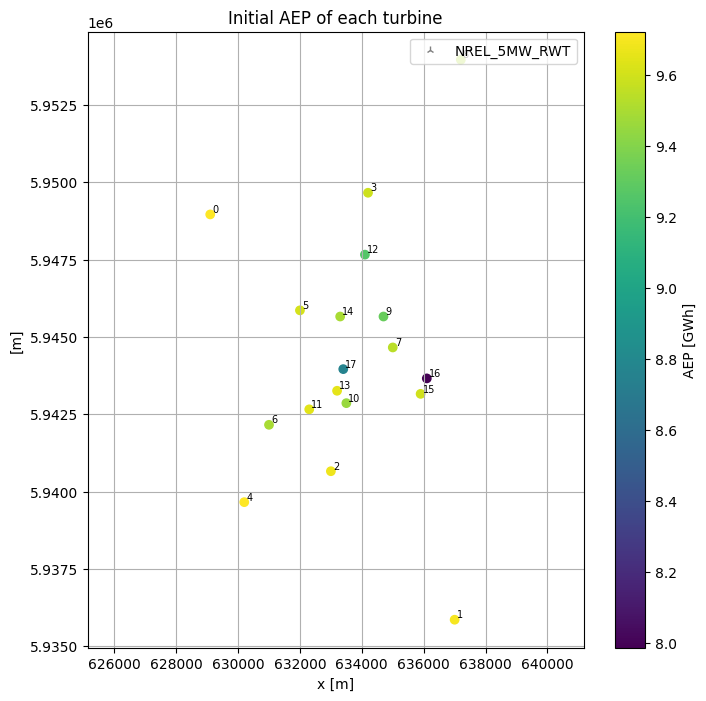

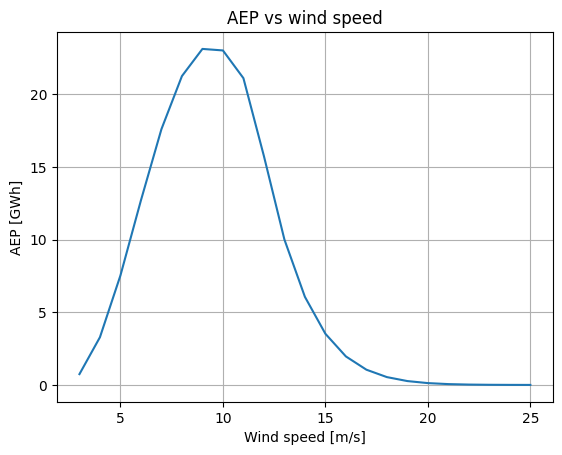

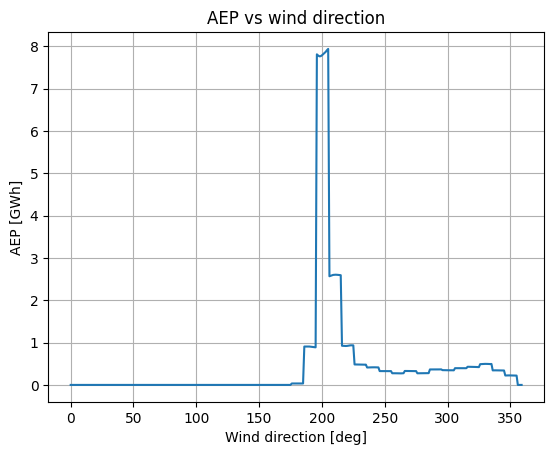

In [11]:
# Con esto visualizamos graficos de AEP por turbina, AEP vs Viento y AEP vs direccion

plt.figure()
plt.figure(figsize=(8,8))
aep = simulationResult.aep()
windturbine.plot(wt18_x,wt18_y)
c =plt.scatter(wt18_x, wt18_y, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.title('Initial AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')
plt.grid(True)

plt.figure()
aep.sum(['wt','wd']).plot()
plt.xlabel("Wind speed [m/s]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind speed')
plt.grid(True)

plt.figure()
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.grid(True)
plt.title('AEP vs wind direction')

Ya teniendo la simulacion lista, se procede a aplicar la optimizacion de las ubicaciones de los aerogeneradores para aumentar el AEP mediante la libreria TOPFARM 

In [12]:
# librerias necesarias
from topfarm import TopFarmProblem # problema para topfarm
from topfarm.plotting import XYPlotComp # graficos
from topfarm.constraint_components.boundary import XYBoundaryConstraint # limites 
from topfarm.easy_drivers import EasyScipyOptimizeDriver # optimizador
from topfarm.cost_models.cost_model_wrappers import CostModelComponent # modelo de costo
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent 

Se utilizan las coordenadas iniciales de los aerogeneradores, se define el numero de estos y ademas se incorporan limites correspondientes a un poligono que demarca el area de emplazamiento (tambien se puede agregar un rango de direcciones a considerar)

In [22]:
# coordendas inciales usadas anteriormente
x = wt18_x
y = wt18_y

n_wt = 18 # numero de turbinas 

# Limites del area de emplazamiento
boundary = np.array([(629805,5955176),(636818,5954603),(637218,5935661),(629002,5936836)])

# se utilizan todas las direcciones en este caso

# para modificar el rango de direcciones puede ser algo de este modo 
#wd3 = np.linspace(160.,360.,210, endpoint=False)

CASO 1: totalidad de datos 

Ahora se definen componentes y el problema TOPFARM

In [29]:
# direcciones a considerar   
wd = np.linspace(0., 360., 360, endpoint=False) 


# Componentes del problema
 
# se utiliza el modelo de coste 'PyWakeAEPCostModelComponent' que es mas rapido para calcular el AEP
# existen otras opciones como la presentada en el caso 2, pero que toman mas tiempo. 


#inputs (WindFarmModel, numero de turbinas, direcciones del viento)
cost_comp = PyWakeAEPCostModelComponent(wfm, n_wt, wd=wd)

# coordendas iniciales de los aerogeneradores
initial =  np.column_stack((x, y))

# Se utiliza el optimizador por defecto SLSQP, con 200 iteraciones y una tolerancia de 1e-2
# se pueden agregar mas iteraciones o tolerancia (decimales de diferencia) pero esto puede aumentar el tiempo de calculo
drivert = EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=200, tol=1e-2)

# por ultimo se definen las variables de dise~no, que son las que se modifican en cada iteracion
# para encontrar el mejor valor de AEP, Se utilian las coordenadas iniciales
design_vars = dict(zip('xy', (initial[:, :2]).T))

# Definicion del objeto topfarm 
tf = TopFarmProblem(
        design_vars, 
        cost_comp=cost_comp, 
        constraints=[XYBoundaryConstraint(boundary)], # Restricciones (coordendas limites)
        driver=drivert,
        plot_comp=XYPlotComp(), # graficar 
        expected_cost=1e-3) #numeros chicos, menor precision. numeros grandes, mas tiempo de demora.

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


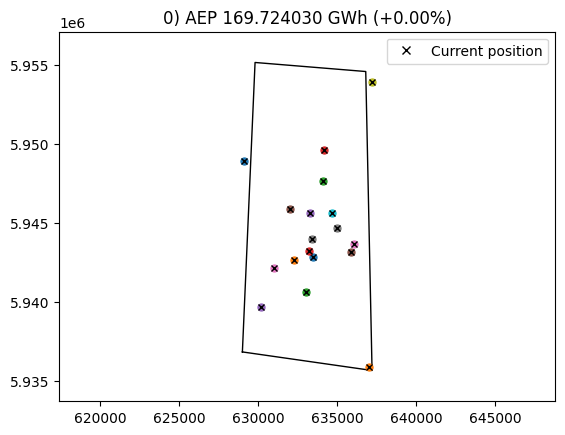

Optimization terminated successfully    (Exit mode 0)
            Current function value: -174368.25153984915
            Iterations: 196
            Function evaluations: 211
            Gradient evaluations: 196
Optimization Complete
-----------------------------------


In [30]:
_, state, _ = tf.optimize()

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


(-174.36825153984915,
 {'x': array([629538.647722  , 636907.60760833, 633747.42134302, 631694.92471287,
         629708.29031699, 629445.58285035, 629253.87240173, 636578.61249816,
         635676.08764149, 636569.21957689, 633744.08587265, 631516.4413937 ,
         634635.51901467, 633734.77723244, 631705.58312187, 636445.96798487,
         637080.82148062, 633719.42285579]),
  'y': array([5949092.68645259, 5935707.78967773, 5940356.53051583,
         5951085.20840651, 5939793.37902467, 5946927.89863758,
         5942588.60255003, 5944122.78406664, 5954495.83342875,
         5945361.81308339, 5941697.78405178, 5942067.27037359,
         5948094.03374526, 5942854.7018964 , 5947373.01468512,
         5942049.53469508, 5942157.08878547, 5943900.27860291])})

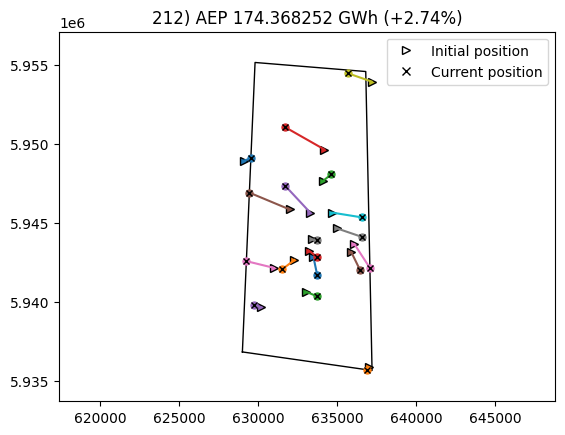

In [32]:
# para mostrar los resultados de la optimizacion
tf.evaluate()

Guardando las nuevas coordenadas, en el formato [x, y] o mas especifico en coordenadas UTM [este, norte] resultando un archivo .txt

In [33]:
state # entrega las nuevas coordenadas

# extraer los valores de las nuevas coordendas de 'state'
x_2 = state['x']
y_2 = state['y']
# Guardar los vectores en un archivo de texto
np.savetxt('coordenadas_optimizadas.txt', np.column_stack((x_2, y_2)), header='x y', comments='', fmt='%.8f')

En las siguientes celdas de codigo se muestran graficos para las coordendas ya optimizadas. Luego de esto se presenta un caso 2, donde se utiliza el 40% mejor de los datos de viento 

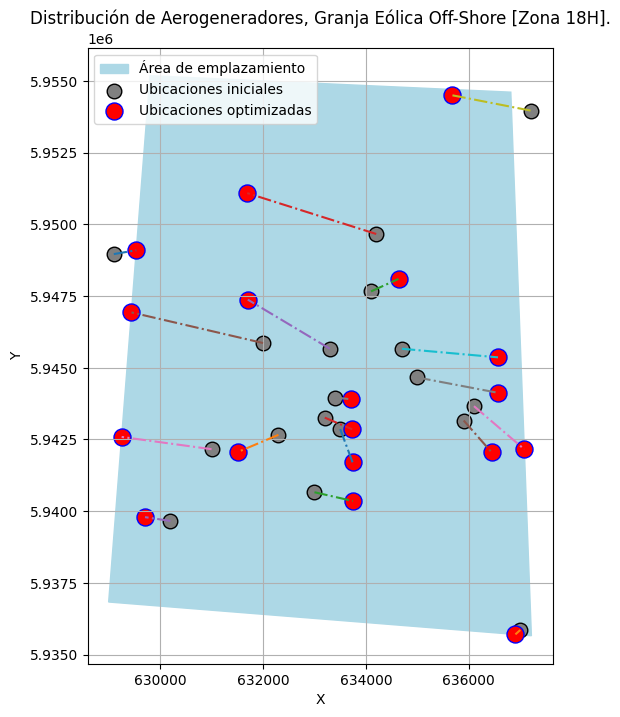

In [34]:
x_coords= [629805,636818,637218,629002]
y_coords= [5955176,5954603,5935661,5936836]

plt.figure(figsize=(6,8))
plt.fill(x_coords, y_coords, color='lightblue', label='Área de emplazamiento')  # Rellenar el polígono con color

plt.scatter(x, y, color='gray', label='Ubicaciones iniciales', s=110, marker='o',edgecolor='black') 
plt.scatter(x_2, y_2, color='red', label='Ubicaciones optimizadas', s=150, marker='o',edgecolor='blue')  # Puedes cambiar 'x' por otro carácter
for xi, yi, x2i, y2i in zip(x, y, x_2, y_2):
    plt.plot([xi, x2i], [yi, y2i], '-.')  # 'k--' indica líneas punteadas en negro
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Distribución de Aerogeneradores, Granja Eólica Off-Shore [Zona 18H].')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

Podemos calcular nuevamente el AEP y mapa de flujo

Total AEP: 174.368252 GWh


Text(0.5, 1.0, 'Wake map: 10 m/s, 200 deg')

<Figure size 640x480 with 0 Axes>

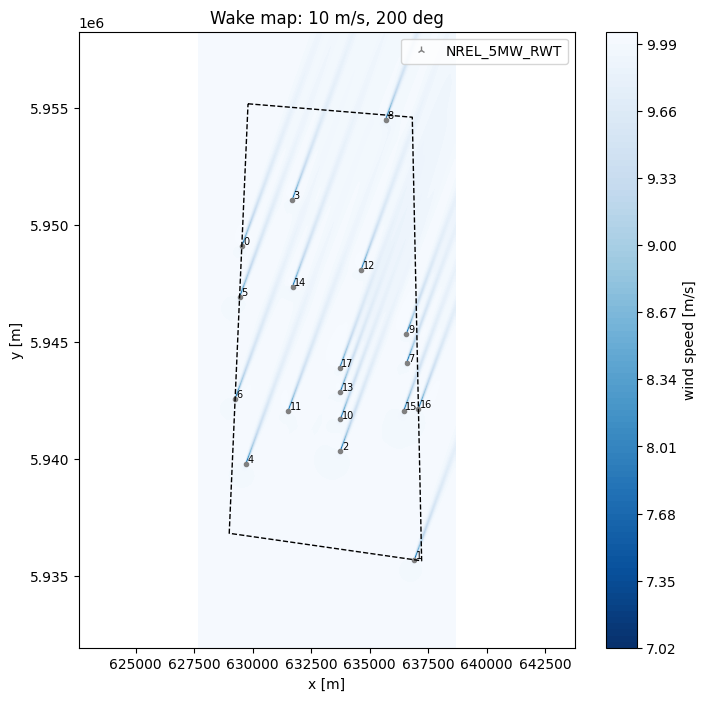

In [38]:
# AEP
simulationResult = wfm(x_2, y_2, wd=wd)
simulationResult.aep()
print ("Total AEP: %f GWh"%simulationResult.aep().sum()) 


wind_direction = 200
plt.figure()
flow_map = simulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(8,8))
flow_map.plot_wake_map()
plt.plot(x_coords + [x_coords[0]], y_coords + [y_coords[0]], color='black', linestyle='--', linewidth=1, label='Polígono')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map:' + f' {wind_speed} m/s, {wind_direction} deg')

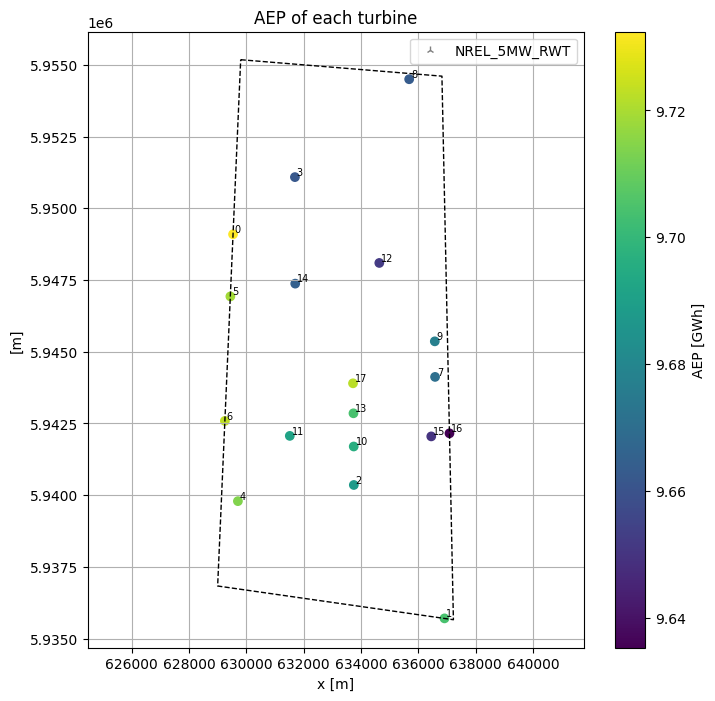

In [39]:
plt.figure(figsize=(8,8))
aep = simulationResult.aep()
windturbine.plot(x_2,y_2)
c =plt.scatter(x_2, y_2, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.plot(x_coords + [x_coords[0]], y_coords + [y_coords[0]], color='black', linestyle='--', linewidth=1, label='Polígono')
plt.title('AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')
plt.grid(True)

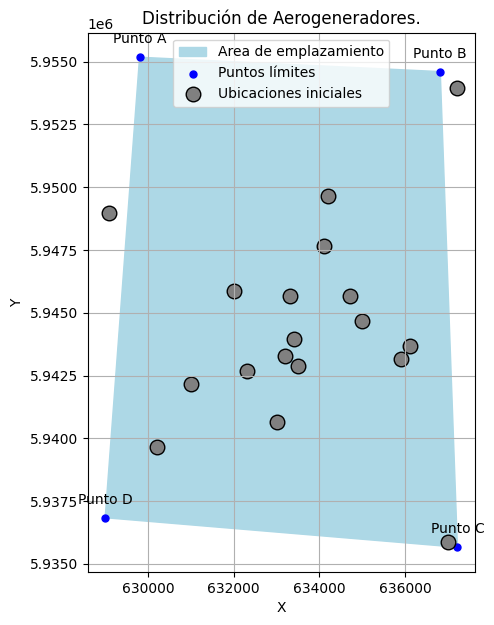

In [40]:
# grafico de posiciones iniclaes de las turbinas
plt.figure(figsize=(5,7))
plt.fill(x_coords, y_coords, color='lightblue', label='Area de emplazamiento')  # Rellenar el polígono con color
plt.scatter(x_coords, y_coords, color='blue', marker='.',s=100, label='Puntos límites')  # Rellenar el polígono con color
for i, txt in enumerate(['Punto A', 'Punto B', 'Punto C', 'Punto D']):
    plt.annotate(txt, (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.scatter(x, y, color='gray', label='Ubicaciones iniciales', s=110, marker='o',edgecolor='black') 
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Distribución de Aerogeneradores.')
plt.legend(loc='upper center')
plt.grid(True)
plt.show()

#############################################

CASO 2 :  Se realiza la misma metodologia, pero para el caso del 40% mejor de los datos de viento.

En este caso simplemente se reemplazan los parametros a,k y f del caso

#######################################################

Se definen entonces las posisiciones inciales y un nuevo Site con la informacion para UniformWeibubllSite del 40% mejor de los datos

Text(0.5, 1.0, 'Rosa de los vientos, caso 2')

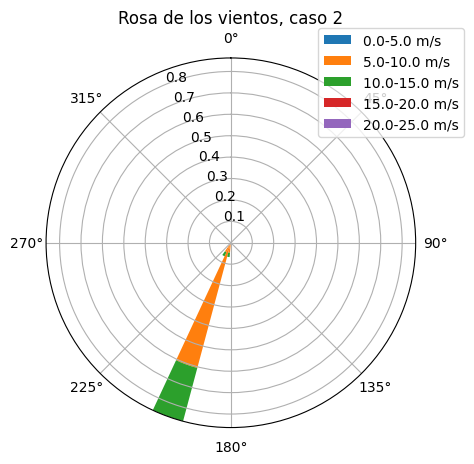

In [34]:
# Posiciones inciales de 18 turbinas, coordenadas UTM
wt18_x = np.array(wt_x)[[1, 80, 40, 52, 12, 30, 20, 60, 82,57, 45, 33, 51, 42, 43, 69, 71, 44]]
wt18_y = np.array(wt_y)[[133, 2, 50, 140, 40, 102, 65, 90, 183,100, 72, 70, 120, 76, 100, 75, 80, 83]]
# SITE
class Prueba2SiteNuevo(UniformWeibullSite):
    #La distribución de Weibull se utiliza para describir la variabilidad de la velocidad del viento en diferentes direcciones.
    def __init__(self, ti=.1, shear=None):
        # se reemplazan estos parametros con la nueva informacion
        f_nuevo = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0671641791044776,0.863184079601990,0.0696517412935323,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        a_nuevo = [9.7046]  *36  
        k_nuevo = 6.3184
        UniformWeibullSite.__init__(self, f_nuevo, a_nuevo, [k_nuevo] * 36, ti=ti, shear=shear)
        self.initial_position = np.array([wt18_x, wt18_y]).T
windturbine = MyTurbine()
site = Prueba2SiteNuevo()
# Rosa de los vientos 
_ = site.plot_wd_distribution(n_wd=36,ws_bins=[0,5,10,15,20,25]) 
plt.title('Rosa de los vientos, caso 2')

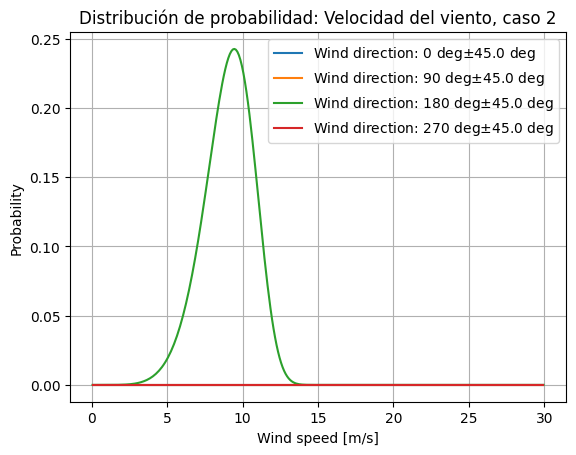

In [35]:
plt.figure()
plt.title('Distribución de probabilidad: Velocidad del viento, caso 2')
_ = site.plot_ws_distribution(wd=[0,90,180,270], include_wd_distribution=True)
plt.grid(True)

Se corre la simulacion, en la parte inferior se muestra el AEP inicial

In [37]:
wfm = All2AllIterative(
    site,
    windturbine,
    wake_deficitModel=FugaDeficit(
        rotorAvgModel=None,
        groundModel=None),
    superpositionModel=LinearSum(),
    deflectionModel=None,
    turbulenceModel=None,
    blockage_deficitModel=FugaDeficit(),
    rotorAvgModel=None)
#tambien podemos hacer el calculo de aep para cierto rango de direcciones
#wd2 = np.linspace(0.,360.,360, endpoint=False)
wd2 = np.linspace(180.,225.,45, endpoint=False)
simulationResult = wfm(wt18_x, wt18_y, wd= wd2)
print ("Total AEP: %f GWh"%simulationResult.aep().sum()) 

Total AEP: 412.449592 GWh


Text(0.5, 1.0, 'Wake Map: 9 m/s, 200 deg')

<Figure size 640x480 with 0 Axes>

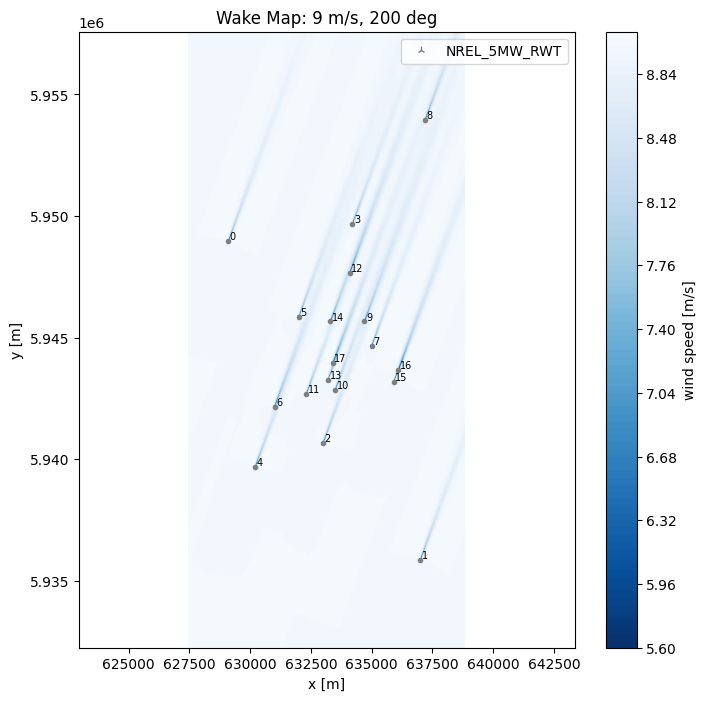

In [38]:
wind_speed = 9 #m/s
wind_direction = 200 # grados, de donde proviene el viento
plt.figure()
flow_map = simulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(8,8))
flow_map.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake Map:' + f' {wind_speed} m/s, {wind_direction} deg')

Text(0.5, 1.0, 'AEP vs wind direction')

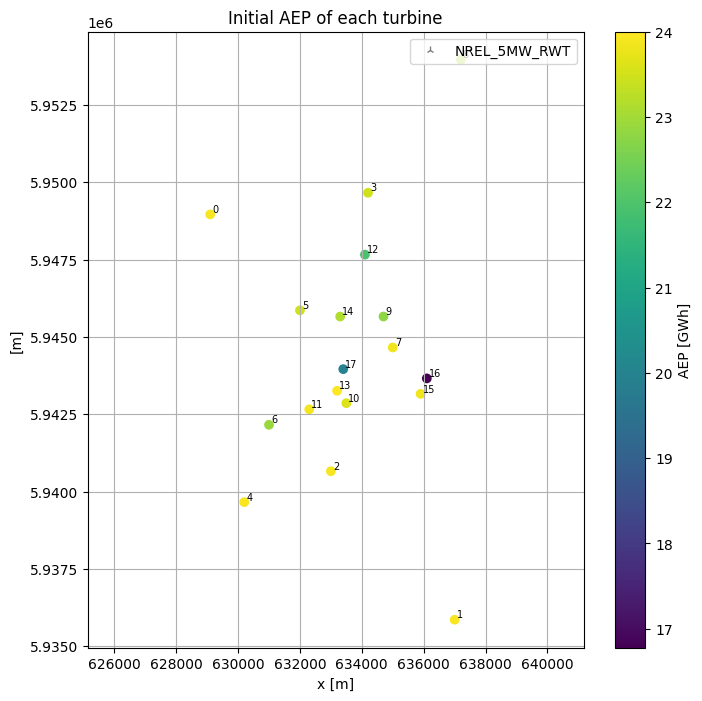

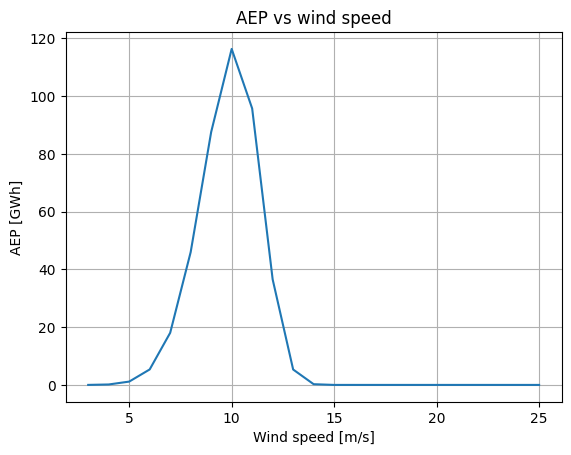

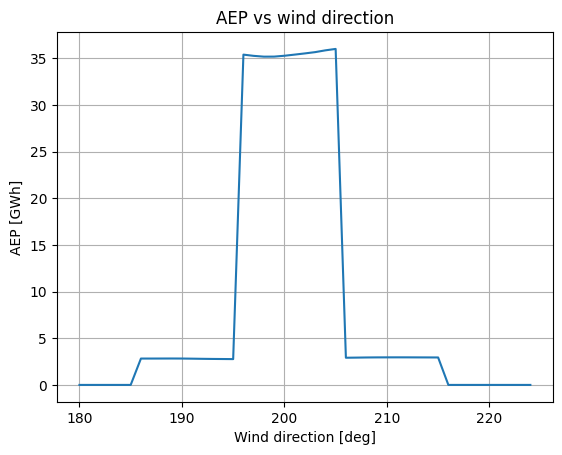

In [39]:
plt.figure(figsize=(8,8))
aep = simulationResult.aep()
windturbine.plot(wt18_x,wt18_y)
c =plt.scatter(wt18_x, wt18_y, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.title('Initial AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')
plt.grid(True)

plt.figure()
aep.sum(['wt','wd']).plot()
plt.xlabel("Wind speed [m/s]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind speed')
plt.grid(True)

plt.figure()
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.grid(True)
plt.title('AEP vs wind direction')

Optimizacion del caso 2: Se deja a disposicion otra forma de crear el problema topfarm sacado de uno de los ejemplos del sitio oficial. (Puede entregar resultados mejores, pero aumenta considerablemente el tiempo de espera (10 -20min))

In [44]:
x = wt18_x
y = wt18_y
n_wt = 18 # numero de turbinas 
boundary = np.array([(629805,5955176),(636818,5954603),(637218,5935661),(629002,5936836)])

In [81]:
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
# con esto se puede definir manualmente el modelo de costo

# se realiza la optimizacion para el rango [180,225[ grados 
wd = np.linspace(180.,225.,45, endpoint=False)

# se define una funcion que calcula el AEP
def aep_func(x,y,wd=wd):
    sim_res = wfm(x,y, wd=wd)
    aep = sim_res.aep().sum()
    return aep

# se define una funcion de modelo de coste
aep_comp = CostModelComponent(input_keys=['x','y'],
                              n_wt=n_wt,
                              cost_function=aep_func,
                              output_keys=[('AEP', 0)],
                              output_unit="GWh",
                              objective=True,
                              maximize=True
                             )

# se define por ultimo el problema topfarm
problem2 = TopFarmProblem(design_vars={'x': x, 'y': y},
                          n_wt=n_wt,
                          cost_comp=aep_comp,
                          constraints=[XYBoundaryConstraint(boundary)],
                          driver=EasyScipyOptimizeDriver(disp=False,optimizer='SLSQP', maxiter=400, tol=1e-2),
                          plot_comp=XYPlotComp(),
                          expected_cost=1e-2
                        )

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


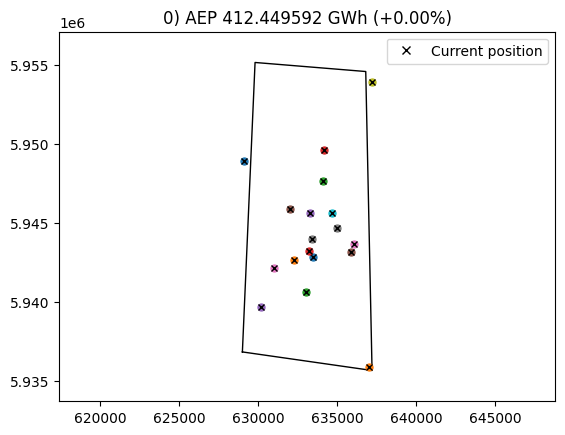

In [82]:
_, state, _ = problem2.optimize()

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


(-431.1065375995729,
 {'x': array([629533.25937974, 637000.83919549, 634202.68746195, 631467.04876509,
         630965.41175377, 629455.67248021, 629657.211157  , 636468.02204758,
         636261.12354307, 636379.01736796, 634225.81707773, 633070.82934736,
         633188.90340531, 634127.48635256, 631504.97349198, 636637.9485704 ,
         637054.92710283, 633513.1874679 ]),
  'y': array([5948934.30669169, 5935861.22309962, 5941013.47066722,
         5950523.35980851, 5939353.65793577, 5946807.86530614,
         5942875.71615643, 5943875.78213196, 5954109.49875013,
         5944844.44124694, 5942576.35885541, 5942292.85937463,
         5948295.75678687, 5943278.72061694, 5946123.10490032,
         5943134.89202174, 5943383.31704565, 5942649.12885099])})

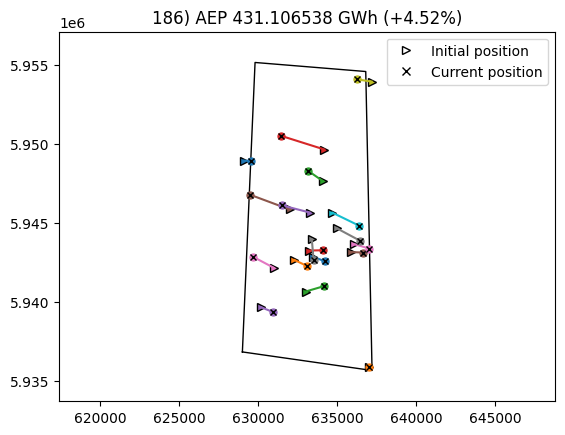

In [96]:
problem2.evaluate()

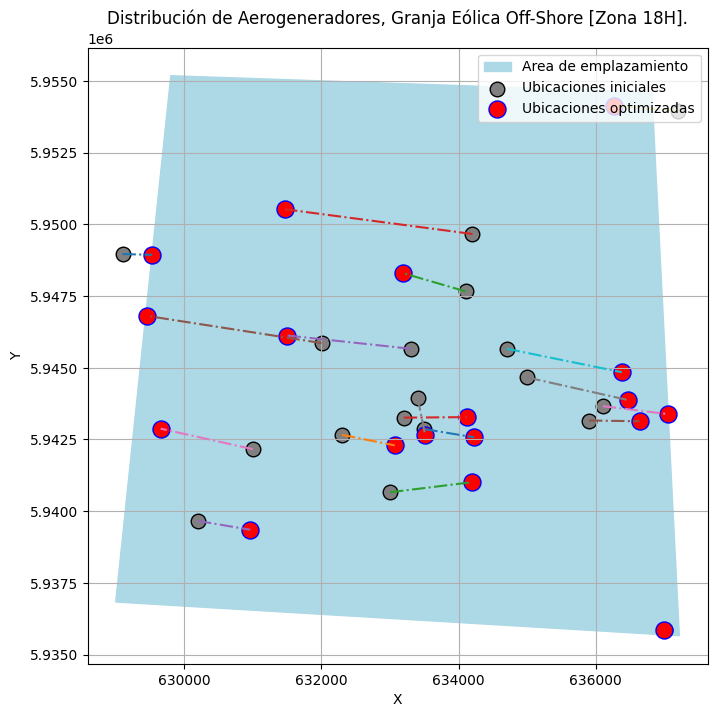

In [84]:
x_2= ([629533.25937974, 637000.83919549, 634202.68746195, 631467.04876509,
         630965.41175377, 629455.67248021, 629657.211157  , 636468.02204758,
         636261.12354307, 636379.01736796, 634225.81707773, 633070.82934736,
         633188.90340531, 634127.48635256, 631504.97349198, 636637.9485704 ,
         637054.92710283, 633513.1874679 ])
y_2 =([5948934.30669169, 5935861.22309962, 5941013.47066722,
         5950523.35980851, 5939353.65793577, 5946807.86530614,
         5942875.71615643, 5943875.78213196, 5954109.49875013,
         5944844.44124694, 5942576.35885541, 5942292.85937463,
         5948295.75678687, 5943278.72061694, 5946123.10490032,
         5943134.89202174, 5943383.31704565, 5942649.12885099])

# anadir que creeun archivo txt

x_coords= [629805,636818,637218,629002]
y_coords= [5955176,5954603,5935661,5936836]

plt.figure(figsize=(8,8))
plt.fill(x_coords, y_coords, color='lightblue', label='Area de emplazamiento')  # Rellenar el polígono con color

plt.scatter(x, y, color='gray', label='Ubicaciones iniciales', s=110, marker='o',edgecolor='black') 
plt.scatter(x_2, y_2, color='red', label='Ubicaciones optimizadas', s=150, marker='o',edgecolor='blue')  # Puedes cambiar 'x' por otro carácter
for xi, yi, x2i, y2i in zip(x, y, x_2, y_2):
    plt.plot([xi, x2i], [yi, y2i], '-.')  # 'k--' indica líneas punteadas en negro
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Distribución de Aerogeneradores, Granja Eólica Off-Shore [Zona 18H].')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Total AEP: 431.106538 GWh


Text(0.5, 1.0, 'Wake map: 9 m/s, 200 deg')

<Figure size 640x480 with 0 Axes>

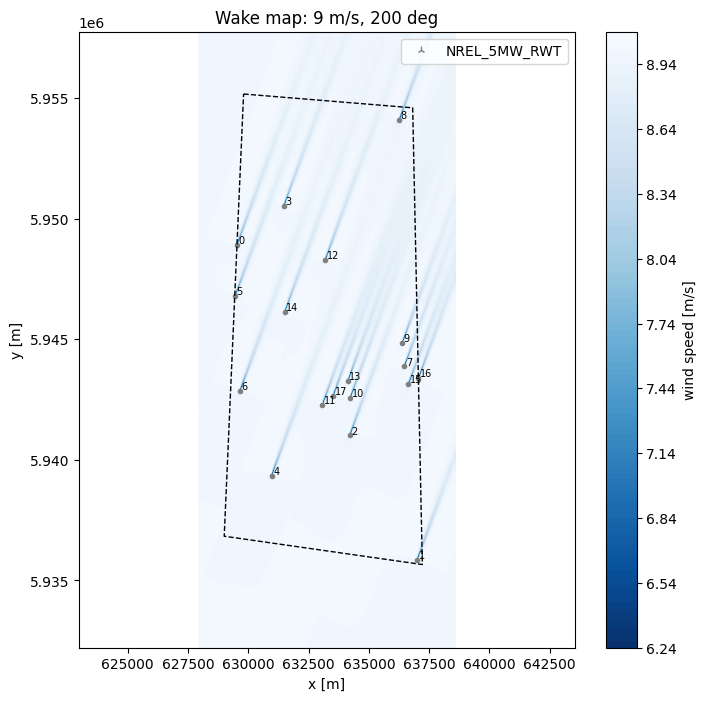

In [85]:
# AEP
simulationResult = wfm(x_2, y_2, wd=wd)
simulationResult.aep()
print ("Total AEP: %f GWh"%simulationResult.aep().sum()) 


wind_direction = 200
plt.figure()
flow_map = simulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(8,8))
flow_map.plot_wake_map()
plt.plot(x_coords + [x_coords[0]], y_coords + [y_coords[0]], color='black', linestyle='--', linewidth=1, label='Polígono')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map:' + f' {wind_speed} m/s, {wind_direction} deg')

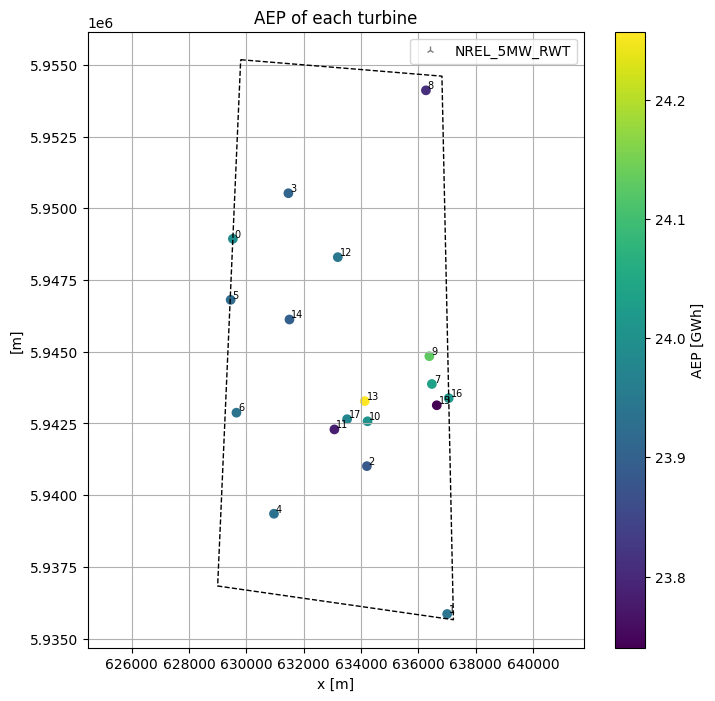

In [86]:
plt.figure(figsize=(8,8))
aep = simulationResult.aep()
windturbine.plot(x_2,y_2)
c =plt.scatter(x_2, y_2, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.plot(x_coords + [x_coords[0]], y_coords + [y_coords[0]], color='black', linestyle='--', linewidth=1, label='Polígono')
plt.title('AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')
plt.grid(True)